In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import pyabc
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from plotting_tools import * 

In [12]:
memilio_pop = 8
experiment_series = f"pop{memilio_pop}"

plot_path = f"../plots//memilio_fits"
os.makedirs(plot_path, exist_ok=True)

In [13]:
result_path = "../../raw_memilio_data/"
result_path_ww = f"../../preprocessing/preprocessed_data/{experiment_series}/"

observed_prev = [329, 2350, 6136, 6279, 4679, 3357, 2421, 1757] # extracted from Contento et al.
observed_prev_full = [329, 2350, 6136, 6279, 4679, 3357, 2421, 1757, 1279, 950, 693, 521, 379] # extracted from Contento et al.

In [14]:
db_path = f"{result_path}/abm_est_output/abm.db"
history = pyabc.History("sqlite:///" + db_path)
population = history.get_population(memilio_pop)
particle = population.get_particles_by_model()[0]

seeds = []
for i in range(0, 300):
    seeds.append(particle[i].sum_stat["seed"])

In [15]:
def comps_by_week(memilio_id):
    curr_seed = seeds[memilio_id - 1]
    df = pd.read_csv(f"{result_path}/abm_est_output/{curr_seed}_comps.csv", sep=" ", index_col=False)
    
    df = df[["t", "S", "E", "Ins", "Isy", "Isev", "Icri", "R", "D"]]
    df.columns = [ "time", "S", "E", "I_ns", "I_sy", "I_sev", "I_cri", "R", "D"]
    df["I_total"] = df["I_ns"] + df["I_sy"] + df["I_sev"] + df["I_cri"]
    df["memilio_id"] = memilio_id
    
    df = df[[(x <= 1343) for x in df["time"]]]
    df['week'] = np.floor(df['time'] / 24 / 7)
    df = df.groupby(['week']).agg({'I_total':"mean", "memilio_id":"first"})
    
    return df

In [16]:
fits = [comps_by_week(memilio_id) for memilio_id in range(1, 301)]
fits = pd.concat(fits)
fits['category'] = "Result (gen. 9)"

In [17]:
target_data = {'I_total': observed_prev, "memilio_id": [-1] * 8, "category": ["Empirical data"] * 8}
target =  pd.DataFrame(target_data)
fits = pd.concat([fits, target]).reset_index()

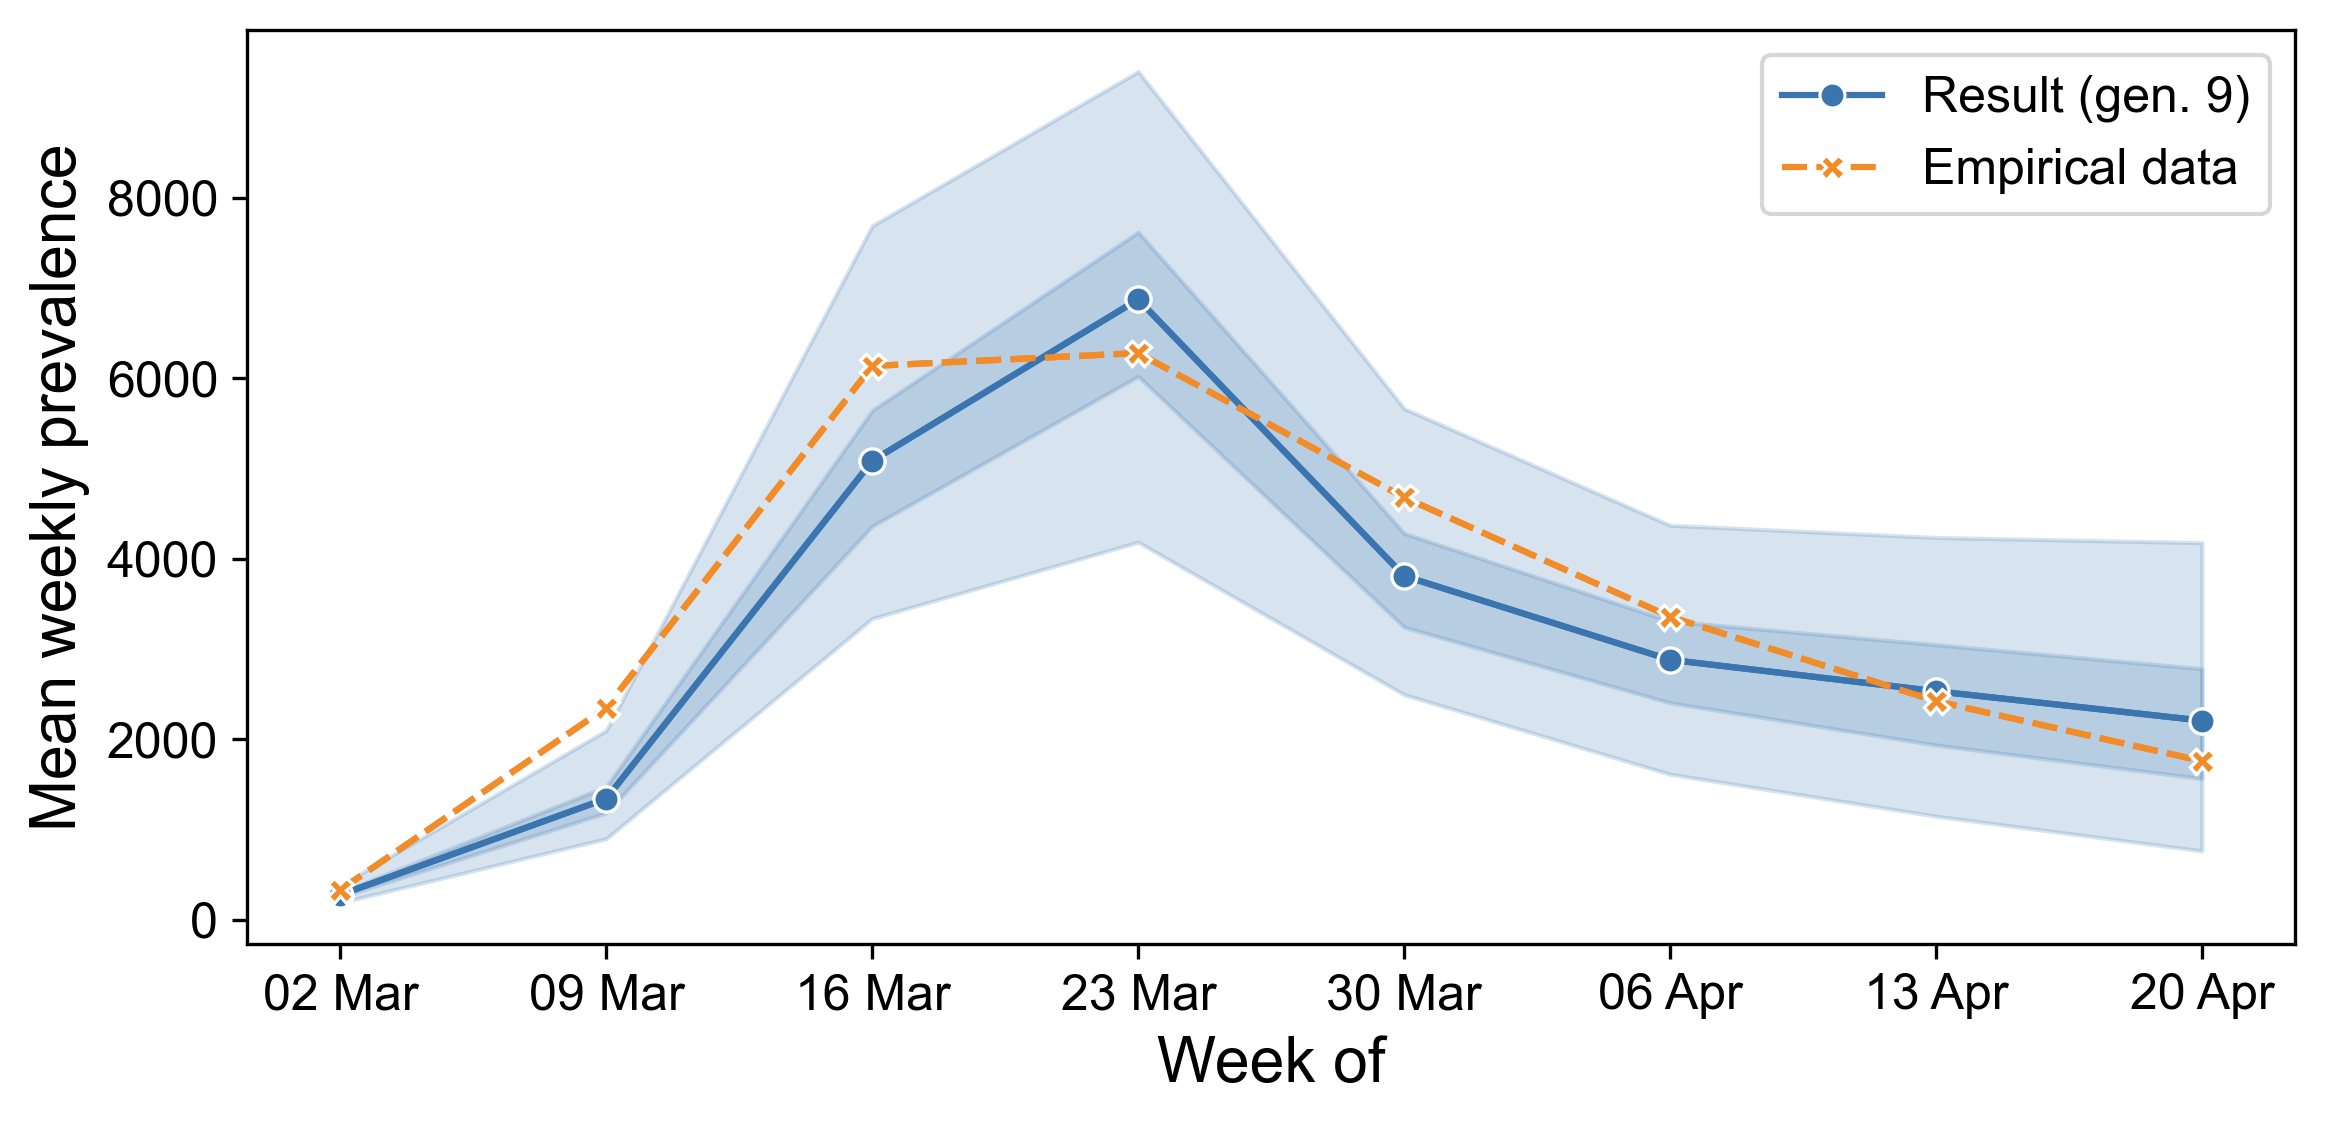

In [18]:
plt.style.use('default')
set_fontsize()

fig, ax = plt.subplots(figsize = (8, 4), dpi = 300)

sns.lineplot(data = fits, x="index", y = "I_total", hue = "category", style = "category", palette=['#3B75AF', '#F28C28'], markers = True, errorbar = ("pi", 100))
sns.lineplot(data = fits, x="index", y = "I_total", hue = "category", style = "category", palette=['#3B75AF', '#F28C28'], markers = True, errorbar = ("pi", 50), legend=None)

ax.set_xlabel("Week of")
ax.set_ylabel("Mean weekly prevalence")
ax.set_xticks(range(0, 8))
ax.set_xticklabels(["02 Mar", "09 Mar", "16 Mar", "23 Mar", "30 Mar", "06 Apr", "13 Apr", "20 Apr"])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])

plt.tight_layout()
plt.savefig(f"{plot_path}/prev_fits.png", dpi=300)
plt.show()

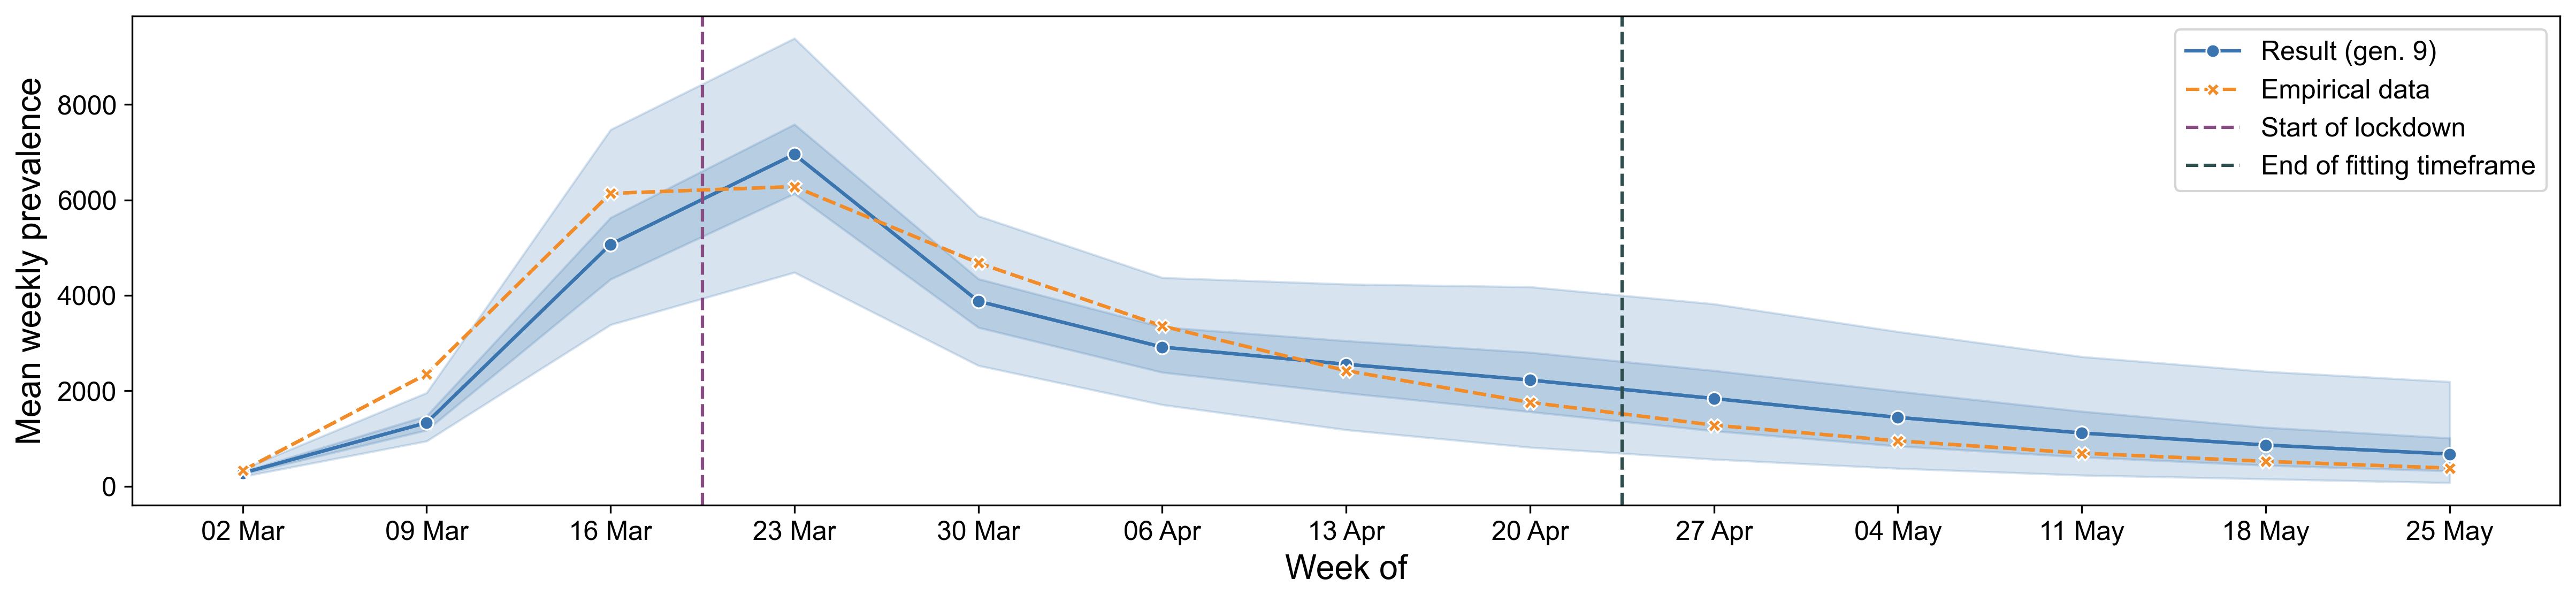

In [20]:
def comps_by_week_full_tf(memilio_id):
    df = pd.read_csv(f"{result_path}/{experiment_series}/comps/{memilio_id}_comps.csv", sep=" ", index_col=False)
    
    df = df[["t", "S", "E", "Ins", "Isy", "Isev", "Icri", "R", "D"]]
    df.columns = [ "time", "S", "E", "I_ns", "I_sy", "I_sev", "I_cri", "R", "D"]
    df["I_total"] = df["I_ns"] + df["I_sy"] + df["I_sev"] + df["I_cri"]
    df["memilio_id"] = memilio_id
    
    df = df[[(x <= 2183) for x in df["time"]]]
    df['week'] = np.floor(df['time'] / 24 / 7)
    df = df.groupby(['week']).agg({'I_total':"mean", "memilio_id":"first"})
    
    return df

fits_full_tf = [comps_by_week_full_tf(memilio_id) for memilio_id in range(1, 101)]
fits_full_tf = pd.concat(fits_full_tf)
fits_full_tf['category'] = "Result (gen. 9)"

target_data_full = {'I_total': observed_prev_full, "memilio_id": [-1] * 13, "category": ["Empirical data"] * 13}
target_data_full =  pd.DataFrame(target_data_full)
fits_full = pd.concat([fits_full_tf, target_data_full]).reset_index()

plt.style.use('default')
set_fontsize()

fig, ax = plt.subplots(figsize = (16.3, 4), dpi = 300)

sns.lineplot(data = fits_full, x="index", y = "I_total", hue = "category", style = "category", palette=['#3B75AF', '#F28C28'], markers = True, errorbar = ("pi", 100))
sns.lineplot(data = fits_full, x="index", y = "I_total", hue = "category", style = "category", palette=['#3B75AF', '#F28C28'], markers = True, errorbar = ("pi", 50), legend=None)

plt.axvline(2.5, 0, max(fits_full["I_total"]), color = "#874C82", linestyle = "--")
plt.axvline(7.5, 0, max(fits_full["I_total"]), color = "#2F4F4F", linestyle = "--")

ax.set_xlabel("Week of")
ax.set_ylabel("Mean weekly prevalence")
ax.set_xticks(range(0, 13))
ax.set_xticklabels(["02 Mar", "09 Mar", "16 Mar", "23 Mar", "30 Mar", "06 Apr", "13 Apr", "20 Apr", "27 Apr", "04 May", "11 May", "18 May", "25 May"])

handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], color="#874C82", linestyle="--", label="Start of lockdown")
line2 = Line2D([0], [0], color="#2F4F4F", linestyle="--", label="End of fitting timeframe")
handles.extend([line1, line2])
labels.extend(["Start of lockdown", "End of fitting timeframe"])
ax.legend(handles=handles[0:], labels=labels[0:])

plt.tight_layout()
plt.savefig(f"{plot_path}/prev_fits_full_tf.png", dpi=300)
plt.show()

In [ ]:
df_measurements = pd.read_csv(f"{result_path_ww}/../concentration_measurements.csv")
df_measurements["category"] = "Empirical concentration"
df_measurements["Date"] = pd.to_datetime(df_measurements["Date"]) 
df_measurements = df_measurements[df_measurements["Value"] > 37.5]

df_sim = pd.read_csv(f"{result_path_ww}/substances/decay_Rain_output_scaled.csv") 
df_sim["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_sim["time_in_minutes"], unit="min")
df_sim = df_sim[df_sim['Date'].isin([pd.to_datetime("2020-04-16 10:00:00"), pd.to_datetime("2020-04-28 10:00:00"), pd.to_datetime("2020-05-05 10:00:00"),
                                     pd.to_datetime("2020-05-19 10:00:00"), pd.to_datetime("2020-05-26 10:00:00")])]
df_sim = df_sim[df_sim['variable'].isin(["COV19"]) & (df_sim["manhole"].isin(manhole_names.keys()))]

df_sim["manhole_clear"] = df_sim["manhole"].apply(lambda x: manhole_names[x])
df_sim = df_sim[df_sim['manhole_clear'].isin(df_measurements['Location'])]
df_sim["category"] = "Simulated concentration"

df_sim['Date'] = df_sim['Date'].dt.strftime('%d %b')
df_measurements['Date'] = df_measurements['Date'].dt.strftime('%d %b')

In [ ]:
plt.style.use('default')
set_fontsize()

fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)

sns.lineplot(data = df_sim, x="Date", y="value", marker="o", label="Simulated virus levels", ax=ax, color="#3B75AF", errorbar = ("pi", 90), estimator=np.median)
sns.lineplot(data = df_sim, x="Date", y="value", marker="o", ax=ax, color="#3B75AF", errorbar = ("pi", 50), legend = None, estimator=np.median)

sns.scatterplot(data= df_measurements, x="Date", y="Value", marker="^", label="Empirical virus levels", ax=ax, color="#F28C28")

ax.set_ylabel("SARS-CoV-2 virus levels [copies/l]")

ax2 = ax.twinx()
prev_values = [2400, 1400, 1050, 550, 400] # from Contento et al. for 16 Apr, 28 Apr, 05 May, 19 May, 26 May
sns.scatterplot(x = df_sim["Date"].unique(), y = prev_values, marker="D", color="#874C82", label="Empirical prevalence", alpha = 0.8, legend = None)
ax2.set_ylabel("Prevalence [#]")
ax2.set(ylim=(ax.get_ylim()[0], ax.get_ylim()[1] * prev_values[0] / df_sim.loc[(df_sim["Date"] == "16 Apr"),"value"].median()))

ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend(handles, labels, loc="best")

plt.tight_layout()
plt.savefig(f"{plot_path}/conc_fits.png", dpi=300)
plt.show()

In [ ]:
all_pops = history.get_all_populations()
all_pops = pd.concat([all_pops, all_pops["population_end_time"].shift()], axis=1).dropna()
all_pops.columns = ["t", "end_time", "samples", "epsilon", "particles", "start_time"]
all_pops['diff_minutes'] = (all_pops['end_time'] - all_pops['start_time']).dt.total_seconds() / 60
all_pops['diff_rounded_hours'] = (all_pops['diff_minutes'] / 30).round() * 0.5
print(all_pops)

In [ ]:
pop_0 = history.get_population(0)
particles_0 = pop_0.get_particles_by_model()[0]
dists_pop0 = []
for i in range(0, 300):
    temp = particles_0[i]
    dists_pop0.append(temp.distance)

pop_1 = history.get_population(1)
particles_1 = pop_1.get_particles_by_model()[0]
dists_pop1 = []
for i in range(0, 300):
    temp = particles_1[i]
    dists_pop1.append(temp.distance)
    
pop_2 = history.get_population(2)
particles_2 = pop_2.get_particles_by_model()[0]
dists_pop2 = []
for i in range(0, 300):
    temp = particles_2[i]
    dists_pop2.append(temp.distance)
    
pop_3 = history.get_population(3)
particles_3 = pop_3.get_particles_by_model()[0]
dists_pop3 = []
for i in range(0, 300):
    temp = particles_3[i]
    dists_pop3.append(temp.distance)
    
pop_4 = history.get_population(4)
particles_4 = pop_4.get_particles_by_model()[0]
dists_pop4 = []
for i in range(0, 300):
    temp = particles_4[i]
    dists_pop4.append(temp.distance)

pop_5 = history.get_population(5)
particles_5 = pop_5.get_particles_by_model()[0]
dists_pop5 = []
for i in range(0, 300):
    temp = particles_5[i]
    dists_pop5.append(temp.distance)
    
pop_6 = history.get_population(6)
particles_6 = pop_6.get_particles_by_model()[0]
dists_pop6 = []
for i in range(0, 300):
    temp = particles_6[i]
    dists_pop6.append(temp.distance)
    
pop_7 = history.get_population(7)
particles_7 = pop_7.get_particles_by_model()[0]
dists_pop7 = []
for i in range(0, 300):
    temp = particles_7[i]
    dists_pop7.append(temp.distance)

pop_8 = history.get_population(8)
particles_8 = pop_8.get_particles_by_model()[0]
dists_pop8 = []
for i in range(0, 300):
    temp = particles_8[i]
    dists_pop8.append(temp.distance)

pop_9 = history.get_population(9)
particles_9 = pop_9.get_particles_by_model()[0]
dists_pop9 = []
for i in range(0, 300):
    temp = particles_9[i]
    dists_pop9.append(temp.distance)

In [ ]:
def calc_distance(path, memilio_id):

    file_name = []
    regex = re.compile(f"({memilio_id}_.*csv$)")
    for root, dirs, files in os.walk(path):
        for file in files:
            if regex.match(file):
                file_name = file
    df = pd.read_csv(os.path.join(path, str(file_name)), sep=" ", index_col=False)

    df["prev"] = df["Ins"] + df["Isy"] + df["Isev"] + df["Icri"]
    df = df[[(x <= 1343) for x in df["t"]]]
    df['week'] = np.floor(df['t'] / 24 / 7)
    result = df.groupby(['week'])['prev'].mean().to_list()
    dist = np.linalg.norm(np.array(result) - np.array(observed_prev))

    return dist

In [ ]:
rand_seeds_pop0_path = f"{result_path}/pop0_rand/"
rand_seeds_pop0_dists = [calc_distance(rand_seeds_pop0_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop1_path = f"{result_path}/pop1_rand/"
rand_seeds_pop1_dists = [calc_distance(rand_seeds_pop1_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop2_path = f"{result_path}/pop2_rand/"
rand_seeds_pop2_dists = [calc_distance(rand_seeds_pop2_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop3_path = f"{result_path}/pop3_rand/"
rand_seeds_pop3_dists = [calc_distance(rand_seeds_pop3_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop4_path = f"{result_path}/pop4_rand/"
rand_seeds_pop4_dists = [calc_distance(rand_seeds_pop4_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop5_path = f"{result_path}/pop5_rand/"
rand_seeds_pop5_dists = [calc_distance(rand_seeds_pop5_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop6_path = f"{result_path}/pop6_rand/"
rand_seeds_pop6_dists = [calc_distance(rand_seeds_pop6_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop7_path = f"{result_path}/pop7_rand/"
rand_seeds_pop7_dists = [calc_distance(rand_seeds_pop7_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop8_path = f"{result_path}/pop8_rand/"
rand_seeds_pop8_dists = [calc_distance(rand_seeds_pop8_path, memilio_id) for memilio_id in range(1, 301)]

rand_seeds_pop9_path = f"{result_path}/pop9_rand/"
rand_seeds_pop9_dists = [calc_distance(rand_seeds_pop9_path, memilio_id) for memilio_id in range(1, 301)]

In [ ]:
df_distances_sel = pd.DataFrame({"distance": dists_pop0 + dists_pop1 + dists_pop2 + dists_pop3 +
                                             dists_pop4 + dists_pop5 + dists_pop6 + dists_pop7 +
                                             dists_pop8 + dists_pop9,
                             "population": [1] * 300 + [2] * 300 + [3] * 300 + [4] * 300 + [5] * 300 + 
                                           [6] * 300 + [7] * 300 + [8] * 300 + [9] * 300 + [10] * 300, "category": ["Accepted simulations"] * 3000})
df_distances_rand = pd.DataFrame({"distance": rand_seeds_pop0_dists + rand_seeds_pop1_dists +
                                              rand_seeds_pop2_dists + rand_seeds_pop3_dists + 
                                              rand_seeds_pop4_dists + rand_seeds_pop5_dists + 
                                              rand_seeds_pop6_dists + rand_seeds_pop7_dists + 
                                              rand_seeds_pop8_dists + rand_seeds_pop9_dists,
                             "population": [1] * 300 + [2] * 300 + [3] * 300 + [4] * 300 + 
                                           [5] * 300 + [6] * 300 + [7] * 300  + [8] * 300 +
                                           [9] * 300 + [10] * 300, 
                                  "category": ["Forward simulations"] * 3000})
df_distances = pd.concat([df_distances_rand, df_distances_sel], ignore_index=True)


In [ ]:
all_pops = history.get_all_populations()
df = all_pops.T
samples = df.loc[df.index == "samples"]
samples = samples.transpose()
samples["population"] = range(0, 11, 1)
samples["Acceptance rate"] = 300 / samples["samples"] * 100
samples = samples.drop(0)
print(samples)

In [ ]:
plt.style.use('default')
set_fontsize()

fig, axes = plt.subplots(figsize = (5.8,10), nrows=3, ncols=1, dpi=300)

sns.lineplot(data = df_distances, x = "population", y = "distance", hue = "category", palette=['#8B0000', '#83AF63'], ax = axes[0])
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles=handles[0:], labels=labels[0:])
# axes[0].set_ylabel("Distance")
# axes[0].set_xlabel("Generation")
# axes[0].set(xlabel = None, xticklabels = [])

sns.barplot(data = samples, x = 'population', y = 'samples', color = '#83AF63', ax = axes[1])
axes[1].set_ylabel("Number of samples")
axes[1].set(xlabel = None, xticklabels = [])

sns.pointplot(data=samples, x='population', y='Acceptance rate', ax = axes[2], color = '#83AF63')
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Acceptance rate [%]")
axes[2].set(ylim=(0, 60))

plt.tight_layout()
plt.savefig(f"{plot_path}/generations.png", dpi=300)
plt.show()

In [33]:
def find_threshold_for_sum_below_target(numbers, target_sum=0.1, tolerance=1e-9):
    numbers = sorted(numbers)
    
    # Define bounds
    low = min(numbers)
    high = max(numbers)

    def partial_sum_below(threshold):
        return sum(x for x in numbers if x < threshold)

    # Binary search for the threshold
    while high - low > tolerance:
        mid = (low + high) / 2
        current_sum = partial_sum_below(mid)
        
        if current_sum < target_sum:
            low = mid
        else:
            high = mid

    return (low + high) / 2

def posterior_to_plot_2d(pop_num, x_var, y_var, x_min, x_max, num_x, y_min, y_max, num_y, transition = "normal"):
    df, w = history.get_distribution(0, pop_num)
    if transition == "local":
        post = pyabc.visualization.kde.kde_2d(df, w, x = x_var, xmin = x_min, xmax = x_max, numx = num_x, y = y_var, ymin = y_min, ymax = y_max, numy = num_y, 
                                              kde = pyabc.transition.LocalTransition())
    else:
        post = pyabc.visualization.kde.kde_2d(df, w, x = x_var, xmin = x_min, xmax = x_max, numx = num_x, y = y_var, ymin = y_min, ymax = y_max, numy = num_y)
    post = post[2]
    post = post / sum(sum(post))
    post_list = list(post.flatten())
    th = find_threshold_for_sum_below_target(post_list)
    post[post < th] = np.nan
    post[post >= th] = 1
    post = post[::-1]
    return post

In [60]:
cmap_dict_pop0 = {0: '#FFFFFF', 1: '#eeeeee'}
cmap_pop0 = ListedColormap([cmap_dict_pop0[i] for i in range(2)])

cmap_dict_pop2 = {0: '#FFFFFF', 1: '#cccccc'}
cmap_pop2 = ListedColormap([cmap_dict_pop2[i] for i in range(2)])

cmap_dict_pop4 = {0: '#FFFFFF', 1: '#a2a2a2'}
cmap_pop4 = ListedColormap([cmap_dict_pop4[i] for i in range(2)])

cmap_dict_pop6 = {0: '#FFFFFF', 1: '#595959'}
cmap_pop6 = ListedColormap([cmap_dict_pop6[i] for i in range(2)])

cmap_dict_pop8 = {0: '#FFFFFF', 1: '#3B75AF'}
cmap_pop8 = ListedColormap([cmap_dict_pop8[i] for i in range(2)])

In [ ]:
# kappa vs. init_e – ca. 2min to run
pop0_kappa_init_e = posterior_to_plot_2d(pop_num = 0, x_var = "kappa", y_var = "init_e", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 0.00013, num_y = 1301)
pop2_kappa_init_e = posterior_to_plot_2d(pop_num = 2, x_var = "kappa", y_var = "init_e", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 0.00013, num_y = 1301)
pop4_kappa_init_e = posterior_to_plot_2d(pop_num = 4, x_var = "kappa", y_var = "init_e", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 0.00013, num_y = 1301)
pop6_kappa_init_e = posterior_to_plot_2d(pop_num = 6, x_var = "kappa", y_var = "init_e", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 0.00013, num_y = 1301)
pop8_kappa_init_e = posterior_to_plot_2d(pop_num = 8, x_var = "kappa", y_var = "init_e", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 0.00013, num_y = 1301)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(0, 1, num = 1001)
y_range = np.linspace(0, 0.00013, num = 1301)

sns.heatmap(pop0_kappa_init_e, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_kappa_init_e, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_kappa_init_e, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_kappa_init_e, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_kappa_init_e, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])
# ax.set_xticklabels([x_range[0], x_range[int((len(x_range) - 1) / 2)], x_range[len(x_range) - 1]])
# ax.set_yticklabels([y_range[0], y_range[int((len(y_range) - 1) / 2)], np.format_float_scientific(y_range[len(y_range) - 1])])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/kappa_init_e.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# kappa vs. damp_time – ca. 7min to run
pop0_kappa_damp_time = posterior_to_plot_2d(pop_num = 0, x_var = "kappa", y_var = "damp_time", x_min = 0, x_max = 1, num_x = 1001, y_min = 1, y_max = 49, num_y = 4801)
pop2_kappa_damp_time = posterior_to_plot_2d(pop_num = 2, x_var = "kappa", y_var = "damp_time", x_min = 0, x_max = 1, num_x = 1001, y_min = 1, y_max = 49, num_y = 4801)
pop4_kappa_damp_time = posterior_to_plot_2d(pop_num = 4, x_var = "kappa", y_var = "damp_time", x_min = 0, x_max = 1, num_x = 1001, y_min = 1, y_max = 49, num_y = 4801)
pop6_kappa_damp_time = posterior_to_plot_2d(pop_num = 6, x_var = "kappa", y_var = "damp_time", x_min = 0, x_max = 1, num_x = 1001, y_min = 1, y_max = 49, num_y = 4801)
pop8_kappa_damp_time = posterior_to_plot_2d(pop_num = 8, x_var = "kappa", y_var = "damp_time", x_min = 0, x_max = 1, num_x = 1001, y_min = 1, y_max = 49, num_y = 4801)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(0, 1, num = 1001)
y_range = np.linspace(0, 49, num = 4801)

sns.heatmap(pop0_kappa_damp_time, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_kappa_damp_time, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_kappa_damp_time, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_kappa_damp_time, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_kappa_damp_time, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/kappa_damp_time.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# kappa vs. damp_lvl – ca. 1.5min to run 
pop0_kappa_damp_lvl = posterior_to_plot_2d(pop_num = 0, x_var = "kappa", y_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 1, num_y = 1001)
pop2_kappa_damp_lvl = posterior_to_plot_2d(pop_num = 2, x_var = "kappa", y_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 1, num_y = 1001)
pop4_kappa_damp_lvl = posterior_to_plot_2d(pop_num = 4, x_var = "kappa", y_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 1, num_y = 1001)
pop6_kappa_damp_lvl = posterior_to_plot_2d(pop_num = 6, x_var = "kappa", y_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 1, num_y = 1001)
pop8_kappa_damp_lvl = posterior_to_plot_2d(pop_num = 8, x_var = "kappa", y_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001, y_min = 0, y_max = 1, num_y = 1001)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(0, 1, num = 1001)
y_range = np.linspace(0, 1, num = 1001)

sns.heatmap(pop0_kappa_damp_lvl, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_kappa_damp_lvl, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_kappa_damp_lvl, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_kappa_damp_lvl, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_kappa_damp_lvl, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/kappa_damp_lvl.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# init_e vs. damp_lvl – ca. 2min to run
pop0_init_e_damp_lvl = posterior_to_plot_2d(pop_num = 0, x_var = "init_e", y_var = "damp_lvl", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 0, y_max = 1, num_y = 1001)
pop2_init_e_damp_lvl = posterior_to_plot_2d(pop_num = 2, x_var = "init_e", y_var = "damp_lvl", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 0, y_max = 1, num_y = 1001)
pop4_init_e_damp_lvl = posterior_to_plot_2d(pop_num = 4, x_var = "init_e", y_var = "damp_lvl", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 0, y_max = 1, num_y = 1001)
pop6_init_e_damp_lvl = posterior_to_plot_2d(pop_num = 6, x_var = "init_e", y_var = "damp_lvl", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 0, y_max = 1, num_y = 1001)
pop8_init_e_damp_lvl = posterior_to_plot_2d(pop_num = 8, x_var = "init_e", y_var = "damp_lvl", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 0, y_max = 1, num_y = 1001)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(0, 0.00013, num = 1301)
y_range = np.linspace(0, 1, num = 1001)

sns.heatmap(pop0_init_e_damp_lvl, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_init_e_damp_lvl, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_init_e_damp_lvl, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_init_e_damp_lvl, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_init_e_damp_lvl, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/init_e_damp_lvl.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# init_e vs. damp_time – ca. 8min to run
pop0_init_e_damp_time = posterior_to_plot_2d(pop_num = 0, x_var = "init_e", y_var = "damp_time", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 1, y_max = 49, num_y = 4801, transition = "local")
pop2_init_e_damp_time = posterior_to_plot_2d(pop_num = 2, x_var = "init_e", y_var = "damp_time", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 1, y_max = 49, num_y = 4801, transition = "local")
pop4_init_e_damp_time = posterior_to_plot_2d(pop_num = 4, x_var = "init_e", y_var = "damp_time", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 1, y_max = 49, num_y = 4801, transition = "local")
pop6_init_e_damp_time = posterior_to_plot_2d(pop_num = 6, x_var = "init_e", y_var = "damp_time", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 1, y_max = 49, num_y = 4801, transition = "local")
pop8_init_e_damp_time = posterior_to_plot_2d(pop_num = 8, x_var = "init_e", y_var = "damp_time", x_min = 0, x_max = 0.00013, num_x = 1301, y_min = 1, y_max = 49, num_y = 4801, transition = "local")

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(0, 0.00013, num = 1301)
y_range = np.linspace(1, 49, num = 4801)

sns.heatmap(pop0_init_e_damp_time, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_init_e_damp_time, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_init_e_damp_time, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_init_e_damp_time, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_init_e_damp_time, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/init_e_damp_time.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# damp_time vs. damp_lvl – ca. 7min to run
pop0_damp_time_damp_lvl = posterior_to_plot_2d(pop_num = 0, x_var = "damp_time", y_var = "damp_lvl", x_min = 1, x_max = 49, num_x = 4801, y_min = 0, y_max = 1, num_y = 1001)
pop2_damp_time_damp_lvl = posterior_to_plot_2d(pop_num = 2, x_var = "damp_time", y_var = "damp_lvl", x_min = 1, x_max = 49, num_x = 4801, y_min = 0, y_max = 1, num_y = 1001)
pop4_damp_time_damp_lvl = posterior_to_plot_2d(pop_num = 4, x_var = "damp_time", y_var = "damp_lvl", x_min = 1, x_max = 49, num_x = 4801, y_min = 0, y_max = 1, num_y = 1001)
pop6_damp_time_damp_lvl = posterior_to_plot_2d(pop_num = 6, x_var = "damp_time", y_var = "damp_lvl", x_min = 1, x_max = 49, num_x = 4801, y_min = 0, y_max = 1, num_y = 1001)
pop8_damp_time_damp_lvl = posterior_to_plot_2d(pop_num = 8, x_var = "damp_time", y_var = "damp_lvl", x_min = 1, x_max = 49, num_x = 4801, y_min = 0, y_max = 1, num_y = 1001)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

x_range = np.linspace(1, 49, num = 4801)
y_range = np.linspace(0, 1, num = 1001)

sns.heatmap(pop0_damp_time_damp_lvl, cmap=cmap_pop0, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop2_damp_time_damp_lvl, cmap=cmap_pop2, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop4_damp_time_damp_lvl, cmap=cmap_pop4, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop6_damp_time_damp_lvl, cmap=cmap_pop6, vmin=0, vmax=1, cbar=False, ax = ax)
sns.heatmap(pop8_damp_time_damp_lvl, cmap=cmap_pop8, vmin=0, vmax=1, cbar=False, ax = ax)
ax.set_xticks([0, (len(x_range) - 1) / 2, len(x_range)])
ax.set_yticks([0, (len(y_range) - 1) / 2, len(y_range)])

for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.savefig(f"{plot_path}/damp_time_damp_lvl.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
def posterior_to_plot_1d(pop_num, x_var, x_min, x_max, num_x):
    df, w = history.get_distribution(0, pop_num)
    post = pyabc.visualization.kde.kde_1d(df, w, x = x_var, xmin = x_min, xmax = x_max, numx = num_x)
    post_list = list(map(list, zip(*list(post))))
    return pd.DataFrame(post_list, columns = ["x", "prob"])

In [ ]:
pop0_kappa = posterior_to_plot_1d(pop_num = 0, x_var = "kappa", x_min = 0, x_max = 1, num_x = 1001)
pop2_kappa = posterior_to_plot_1d(pop_num = 2, x_var = "kappa", x_min = 0, x_max = 1, num_x = 1001)
pop4_kappa = posterior_to_plot_1d(pop_num = 4, x_var = "kappa", x_min = 0, x_max = 1, num_x = 1001)
pop6_kappa = posterior_to_plot_1d(pop_num = 6, x_var = "kappa", x_min = 0, x_max = 1, num_x = 1001)
pop8_kappa = posterior_to_plot_1d(pop_num = 8, x_var = "kappa", x_min = 0, x_max = 1, num_x = 1001)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

dfs = [pop0_kappa, pop2_kappa, pop4_kappa, pop6_kappa, pop8_kappa]
max_y = max(df['prob'].max() for df in dfs) * 1.05
min_y = min(df['prob'].min() for df in dfs)

sns.lineplot(pop0_kappa, x = "x", y = "prob", color = '#eeeeee', ax = ax)
sns.lineplot(pop2_kappa, x = "x", y = "prob", color = '#cccccc', ax = ax)
sns.lineplot(pop4_kappa, x = "x", y = "prob", color = '#a2a2a2', ax = ax)
sns.lineplot(pop6_kappa, x = "x", y = "prob", color = '#595959', ax = ax)
sns.lineplot(pop8_kappa, x = "x", y = "prob", color = '#3b75af', ax = ax)

ax.set(ylim=(min_y, max_y))
ax.set_yticks([min_y, max_y / 2, max_y])
ax.set(xlabel = None, ylabel = None, xticklabels = [], yticklabels = [])

for spine in ax.spines.values():
    spine.set_visible(True)

ax.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f"{plot_path}/kappa.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
pop0_init_e = posterior_to_plot_1d(pop_num = 0, x_var = "init_e", x_min = 0, x_max = 0.00013, num_x = 1301)
pop2_init_e = posterior_to_plot_1d(pop_num = 2, x_var = "init_e", x_min = 0, x_max = 0.00013, num_x = 1301)
pop4_init_e = posterior_to_plot_1d(pop_num = 4, x_var = "init_e", x_min = 0, x_max = 0.00013, num_x = 1301)
pop6_init_e = posterior_to_plot_1d(pop_num = 6, x_var = "init_e", x_min = 0, x_max = 0.00013, num_x = 1301)
pop8_init_e = posterior_to_plot_1d(pop_num = 8, x_var = "init_e", x_min = 0, x_max = 0.00013, num_x = 1301)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

dfs = [pop0_init_e, pop2_init_e, pop4_init_e, pop6_init_e, pop8_init_e]
max_y = max(df['prob'].max() for df in dfs) * 1.05
min_y = min(df['prob'].min() for df in dfs)

sns.lineplot(pop0_init_e, x = "x", y = "prob", color = '#eeeeee', ax = ax)
sns.lineplot(pop2_init_e, x = "x", y = "prob", color = '#cccccc', ax = ax)
sns.lineplot(pop4_init_e, x = "x", y = "prob", color = '#a2a2a2', ax = ax)
sns.lineplot(pop6_init_e, x = "x", y = "prob", color = '#595959', ax = ax)
sns.lineplot(pop8_init_e, x = "x", y = "prob", color = '#3b75af', ax = ax)

ax.set(ylim=(min_y, max_y))
ax.set_yticks([min_y, max_y / 2, max_y])
ax.set(xlabel = None, ylabel = None, xticklabels = [], yticklabels = [])

for spine in ax.spines.values():
    spine.set_visible(True)

ax.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f"{plot_path}/init_e.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
pop0_damp_time = posterior_to_plot_1d(pop_num = 0, x_var = "damp_time", x_min = 1, x_max = 49, num_x = 4801)
pop2_damp_time = posterior_to_plot_1d(pop_num = 2, x_var = "damp_time", x_min = 1, x_max = 49, num_x = 4801)
pop4_damp_time = posterior_to_plot_1d(pop_num = 4, x_var = "damp_time", x_min = 1, x_max = 49, num_x = 4801)
pop6_damp_time = posterior_to_plot_1d(pop_num = 6, x_var = "damp_time", x_min = 1, x_max = 49, num_x = 4801)
pop8_damp_time = posterior_to_plot_1d(pop_num = 8, x_var = "damp_time", x_min = 1, x_max = 49, num_x = 4801)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

dfs = [pop0_damp_time, pop2_damp_time, pop4_damp_time, pop6_damp_time, pop8_damp_time]
max_y = max(df['prob'].max() for df in dfs) * 1.05
min_y = min(df['prob'].min() for df in dfs)

sns.lineplot(pop0_damp_time, x = "x", y = "prob", color = '#eeeeee', ax = ax)
sns.lineplot(pop2_damp_time, x = "x", y = "prob", color = '#cccccc', ax = ax)
sns.lineplot(pop4_damp_time, x = "x", y = "prob", color = '#a2a2a2', ax = ax)
sns.lineplot(pop6_damp_time, x = "x", y = "prob", color = '#595959', ax = ax)
sns.lineplot(pop8_damp_time, x = "x", y = "prob", color = '#3b75af', ax = ax)

ax.set(ylim=(min_y, max_y))
ax.set_yticks([min_y, max_y / 2, max_y])
ax.set(xlabel = None, ylabel = None, xticklabels = [], yticklabels = [])

for spine in ax.spines.values():
    spine.set_visible(True)

ax.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f"{plot_path}/damp_time.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
pop0_damp_lvl = posterior_to_plot_1d(pop_num = 0, x_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001)
pop2_damp_lvl = posterior_to_plot_1d(pop_num = 2, x_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001)
pop4_damp_lvl = posterior_to_plot_1d(pop_num = 4, x_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001)
pop6_damp_lvl = posterior_to_plot_1d(pop_num = 6, x_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001)
pop8_damp_lvl = posterior_to_plot_1d(pop_num = 8, x_var = "damp_lvl", x_min = 0, x_max = 1, num_x = 1001)

fig, ax = plt.subplots(figsize = (2.25,2.25), dpi=300) 
set_fontsize()

dfs = [pop0_damp_lvl, pop2_damp_lvl, pop4_damp_lvl, pop6_damp_lvl, pop8_damp_lvl]
max_y = max(df['prob'].max() for df in dfs) * 1.05
min_y = min(df['prob'].min() for df in dfs)

sns.lineplot(pop0_damp_lvl, x = "x", y = "prob", color = '#eeeeee', ax = ax)
sns.lineplot(pop2_damp_lvl, x = "x", y = "prob", color = '#cccccc', ax = ax)
sns.lineplot(pop4_damp_lvl, x = "x", y = "prob", color = '#a2a2a2', ax = ax)
sns.lineplot(pop6_damp_lvl, x = "x", y = "prob", color = '#595959', ax = ax)
sns.lineplot(pop8_damp_lvl, x = "x", y = "prob", color = '#3b75af', ax = ax)

ax.set(ylim=(min_y, max_y))
ax.set_yticks([min_y, max_y / 2, max_y])
ax.set(xlabel = None, ylabel = None, xticklabels = [], yticklabels = [])

for spine in ax.spines.values():
    spine.set_visible(True)

ax.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f"{plot_path}/damp_lvl.png", dpi=300, bbox_inches="tight")
plt.show()